<a href="https://colab.research.google.com/github/CRYPTO-Isaac/RansomwareDECT/blob/main/final_year_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fitting 3 folds for each of 10 candidates, totalling 30 fits
=== Random Forest Confusion Matrix ===
[[8788    2]
 [   0 8789]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8790
           1       1.00      1.00      1.00      8789

    accuracy                           1.00     17579
   macro avg       1.00      1.00      1.00     17579
weighted avg       1.00      1.00      1.00     17579



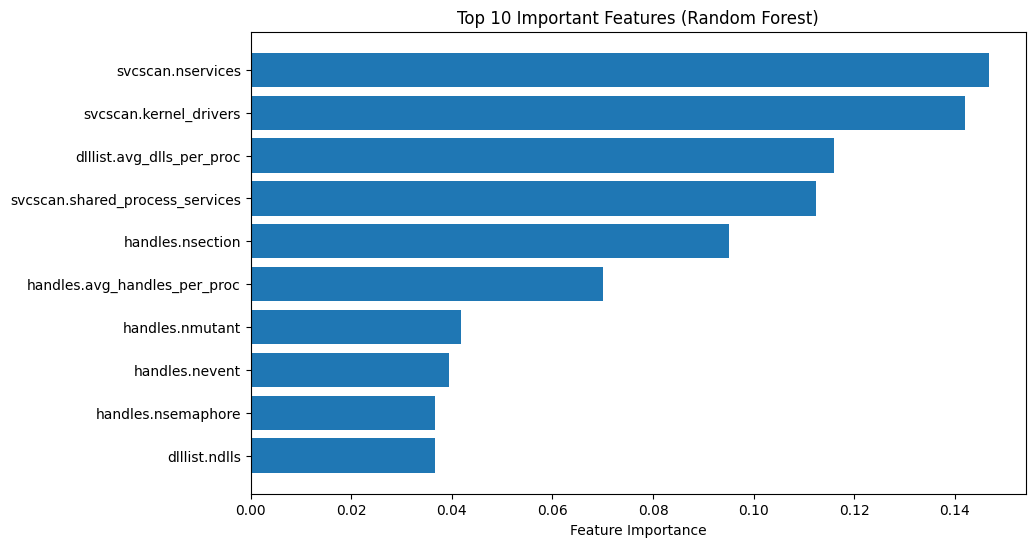

Cross-validation accuracy scores: [0.99982935 1.         1.         0.99385613 1.        ]
Mean accuracy: 0.998737096521008
=== Confusion Matrix (KNN) ===
[[8790    0]
 [   0 8789]]

=== Classification Report (KNN) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8790
           1       1.00      1.00      1.00      8789

    accuracy                           1.00     17579
   macro avg       1.00      1.00      1.00     17579
weighted avg       1.00      1.00      1.00     17579



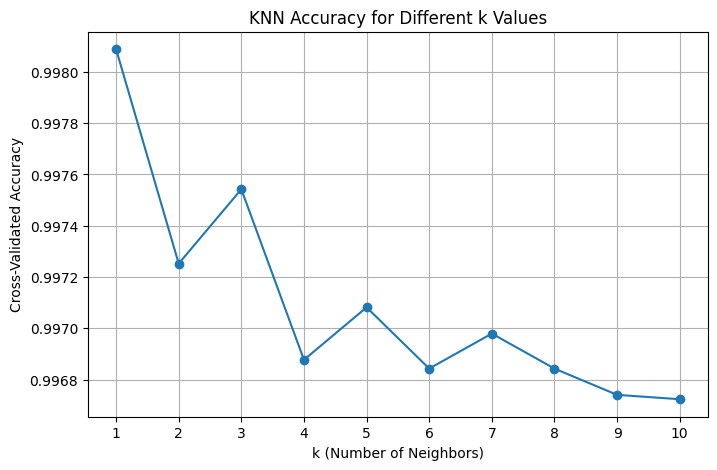

=== Confusion Matrix (SVM) ===
[[8781    9]
 [   3 8786]]

=== Classification Report (SVM) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8790
           1       1.00      1.00      1.00      8789

    accuracy                           1.00     17579
   macro avg       1.00      1.00      1.00     17579
weighted avg       1.00      1.00      1.00     17579

=== Confusion Matrix (PSO-Optimized SVM) ===
[[8788    2]
 [   0 8789]]

=== Classification Report (PSO-Optimized SVM) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8790
           1       1.00      1.00      1.00      8789

    accuracy                           1.00     17579
   macro avg       1.00      1.00      1.00     17579
weighted avg       1.00      1.00      1.00     17579



In [26]:
import pandas as pd

df = pd.read_csv("MalMem2022.csv")
df.head()

df['binary_label'] = df['Category'].apply(lambda x: 0 if x.lower() == 'benign' else 1)

df = df.drop(columns=['Class', 'Category', 'Filename'])

df.isnull().sum().sum()   # Total number of null cells

X = df.drop(columns=['binary_label'])  # All features
y = df['binary_label']                 # Target variable

#Train/ Test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

#Normalise the features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



# === Train a Random Forest Classifier ===

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV


"""
OLD TRAINING OF THE MODEL

# Initialize the model
rf_model = RandomForestClassifier(
    n_estimators=100,        # Number of trees in the forest
    max_depth=None,          # Let trees expand fully
    random_state=42          # For reproducibility
)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)

"""


# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search with 5-fold cross-validation
grid_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=10,        # Only tries 10 random combinations
    cv=3,             # Use 3-fold CV instead of 5
    n_jobs=-1,
    verbose=1,
    random_state=42
)


grid_search.fit(X_train, y_train)

# Get best model from grid search
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)



# Evaluate the model
print("=== Random Forest Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))


# ==== Feature importance plot ====

import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the trained Random Forest model
importances = best_model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features (Random Forest)")
plt.show()


# ==== Cross Validation ====


from sklearn.model_selection import cross_val_score

# Run 5-fold cross-validation
scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

# Print results
print("Cross-validation accuracy scores:", scores)
print("Mean accuracy:", scores.mean())


# === KNN classifier ===


from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

""" Hyperparamter tuning - finding the best 'k'

print("Tuning k (1 to 10)...")
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    print(f"k = {k} → Mean Accuracy: {scores.mean():.4f}")

"""

# Final KNN model using best k
knn_model = KNeighborsClassifier(n_neighbors=1)

# Train the model
knn_model.fit(X_train, y_train)

# Predict on test data
y_pred_knn = knn_model.predict(X_test)

# Evaluate

print("=== Confusion Matrix (KNN) ===")
print(confusion_matrix(y_test, y_pred_knn))

print("\n=== Classification Report (KNN) ===")
print(classification_report(y_test, y_pred_knn))


# code for k vs accuracy (justification for why k is 3)

import matplotlib.pyplot as plt

k_values = list(range(1, 11))
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    accuracies.append(scores.mean())

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o')
plt.title("KNN Accuracy for Different k Values")
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Cross-Validated Accuracy")
plt.xticks(k_values)
plt.grid(True)
plt.show()


# === Baseline SVM classifier ===

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Initialize SVM with RBF kernel (good default)
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Train the model
svm_model.fit(X_train_scaled, y_train)

# Predict
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate
print("=== Confusion Matrix (SVM) ===")
print(confusion_matrix(y_test, y_pred_svm))

print("\n=== Classification Report (SVM) ===")
print(classification_report(y_test, y_pred_svm))



# === PSO-tuned SVM classifier ===

# Use best parameters from PSO
optimal_C = 44.4532454
optimal_gamma = 0.05196937

# Train final model
svm_optimized = SVC(C=optimal_C, gamma=optimal_gamma, kernel='rbf', random_state=42)
svm_optimized.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_optimized = svm_optimized.predict(X_test_scaled)


print("=== Confusion Matrix (PSO-Optimized SVM) ===")
print(confusion_matrix(y_test, y_pred_optimized))

print("\n=== Classification Report (PSO-Optimized SVM) ===")
print(classification_report(y_test, y_pred_optimized))







✅ Total ransomware samples: 9791
🧬 Ransomware families: ['ransomware-ako' 'ransomware-conti' 'ransomware-maze' 'ransomware-pysa'
 'ransomware-shade']
🔢 Label Mapping: {'ransomware-ako': np.int64(0), 'ransomware-conti': np.int64(1), 'ransomware-maze': np.int64(2), 'ransomware-pysa': np.int64(3), 'ransomware-shade': np.int64(4)}
=== Confusion Matrix (Random Forest) ===
[[323  77  68  65  67]
 [ 57 321  80  62  77]
 [ 80  54 363  54  36]
 [ 97  61  73 243  41]
 [ 70  95  42  41 391]]

=== Classification Report (Random Forest) ===
                  precision    recall  f1-score   support

  ransomware-ako       0.52      0.54      0.53       600
ransomware-conti       0.53      0.54      0.53       597
 ransomware-maze       0.58      0.62      0.60       587
 ransomware-pysa       0.52      0.47      0.50       515
ransomware-shade       0.64      0.61      0.63       639

        accuracy                           0.56      2938
       macro avg       0.56      0.56      0.56      2938
 

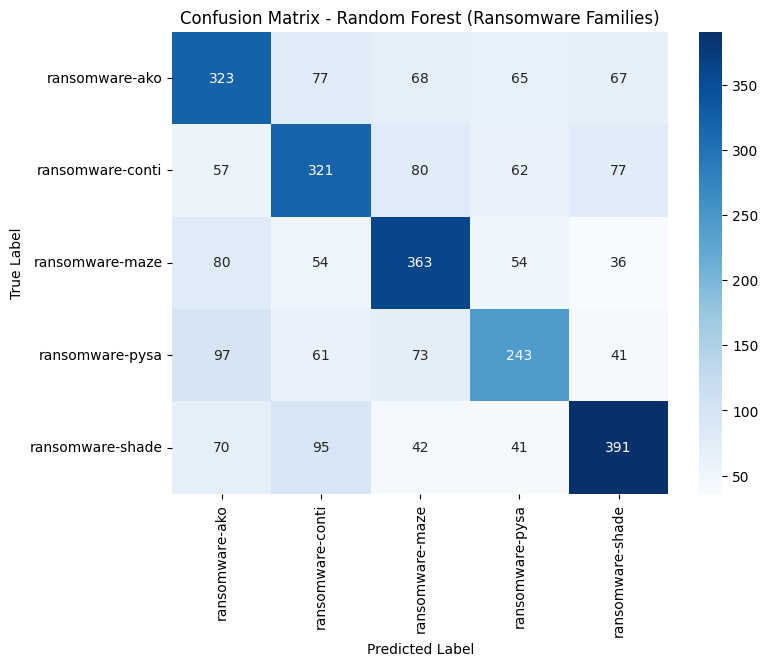

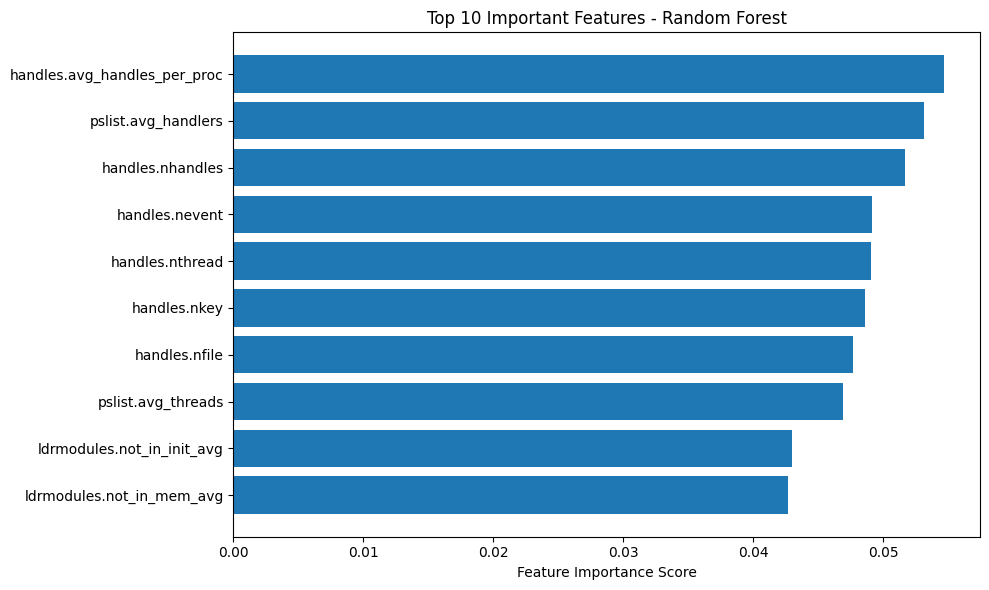

=== Confusion Matrix (KNN) ===
[[242  85  95  92  86]
 [ 77 245 108  59 108]
 [ 85  64 342  58  38]
 [ 99  62  84 219  51]
 [ 79 109  62  73 316]]

=== Classification Report (KNN) ===
                  precision    recall  f1-score   support

  ransomware-ako       0.42      0.40      0.41       600
ransomware-conti       0.43      0.41      0.42       597
 ransomware-maze       0.49      0.58      0.54       587
 ransomware-pysa       0.44      0.43      0.43       515
ransomware-shade       0.53      0.49      0.51       639

        accuracy                           0.46      2938
       macro avg       0.46      0.46      0.46      2938
    weighted avg       0.46      0.46      0.46      2938



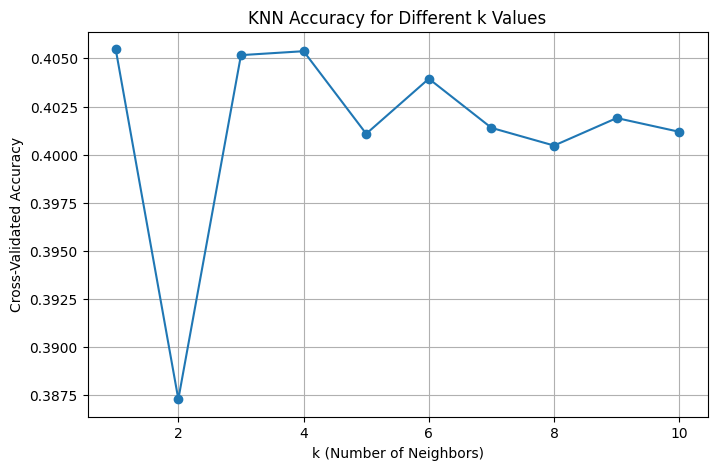

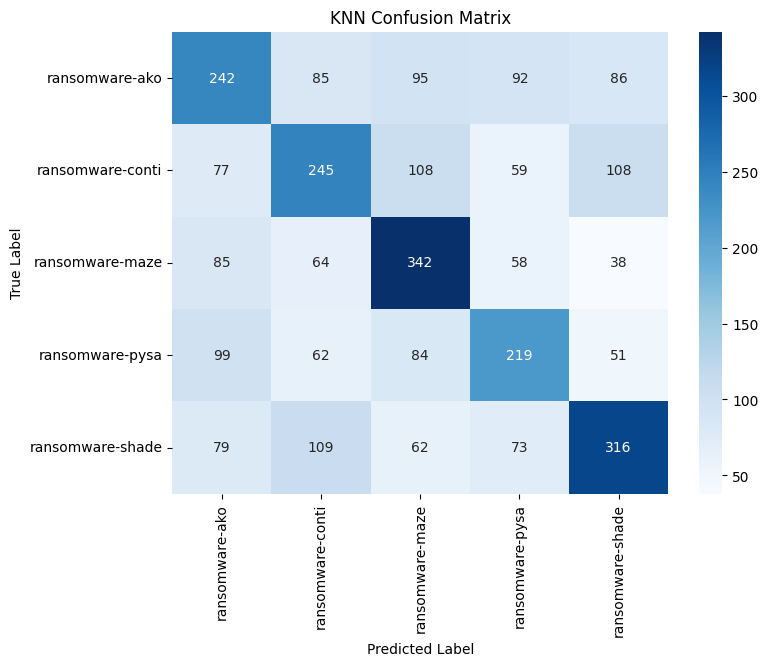

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-05-16 02:15:40,580 - pyswarms.single.global_

=== Confusion Matrix (SVM) ===
[[138   2   0   9 451]
 [  5   5   0   2 585]
 [ 54   0   0   0 533]
 [ 71   0   0  36 408]
 [  0   2   0   0 637]]

=== Classification Report (SVM) ===
                  precision    recall  f1-score   support

  ransomware-ako       0.51      0.23      0.32       600
ransomware-conti       0.56      0.01      0.02       597
 ransomware-maze       0.00      0.00      0.00       587
 ransomware-pysa       0.77      0.07      0.13       515
ransomware-shade       0.24      1.00      0.39       639

        accuracy                           0.28      2938
       macro avg       0.42      0.26      0.17      2938
    weighted avg       0.41      0.28      0.18      2938



pyswarms.single.global_best: 100%|██████████|10/10, best_cost=0.529
2025-05-16 02:34:03,148 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5292571543902274, best pos: [8.75172691e+01 5.21864880e-02]


=== Confusion Matrix (SVM + PSO) ===
[[318 102  56  57  67]
 [ 74 303  89  30 101]
 [118  91 315  24  39]
 [135  64  90 173  53]
 [ 81 106  48  27 377]]

=== Classification Report (SVM + PSO) ===
                  precision    recall  f1-score   support

  ransomware-ako       0.44      0.53      0.48       600
ransomware-conti       0.45      0.51      0.48       597
 ransomware-maze       0.53      0.54      0.53       587
 ransomware-pysa       0.56      0.34      0.42       515
ransomware-shade       0.59      0.59      0.59       639

        accuracy                           0.51      2938
       macro avg       0.51      0.50      0.50      2938
    weighted avg       0.51      0.51      0.50      2938



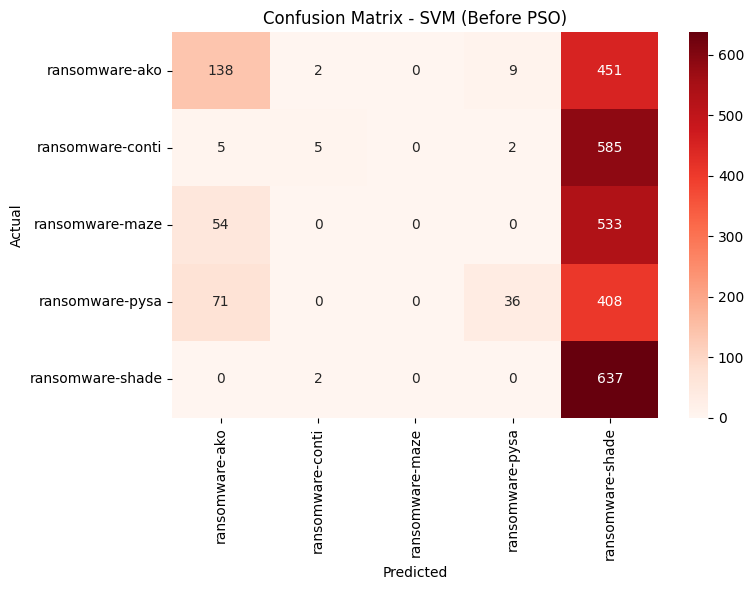

ValueError: Found input variables with inconsistent numbers of samples: [2938, 17579]

In [41]:
import pandas as pd

# Load dataset
df_full = pd.read_csv("MalMem2022.csv")

# Clean the 'Category' column to avoid casing/spacing issues
df_full['Category'] = df_full['Category'].str.strip().str.lower()

# Filter ransomware samples (those that start with 'ransomware')
ransom_df = df_full[df_full['Category'].str.startswith('ransomware')].copy()

# Check output
print("✅ Total ransomware samples:", ransom_df.shape[0])
print("🧬 Ransomware families:", ransom_df['Category'].unique())
ransom_df.head()

# === Preprocessing code block ===



from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



# --- Encode ransomware families ---
label_encoder = LabelEncoder()
ransom_df['family_label'] = label_encoder.fit_transform(ransom_df['Category'])

# Optional: see the mapping
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("🔢 Label Mapping:", label_map)

# --- Drop unused columns ---
ransom_df = ransom_df.drop(columns=['Class', 'Category', 'Filename'])

# --- Define features and labels ---
X = ransom_df.drop(columns=['family_label'])
y = ransom_df['family_label']

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# --- Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# === Random Forest: Ransomware Family Classification ===

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Load dataset (update path if needed)
df = pd.read_csv("MalMem2022.csv")

# Filter only ransomware samples based on the correct column
ransomware_df = df[df['Class'].str.lower() == 'malware']
ransomware_df = ransomware_df[ransomware_df['Category'].str.lower().str.startswith('ransomware')]

# Extract features and target
X = ransomware_df.drop(columns=['Class', 'Category', 'Filename'])  # Features
y = ransomware_df['Category'].str.lower()  # Ransomware families (target)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test_scaled)

print("=== Confusion Matrix (Random Forest) ===")
print(confusion_matrix(y_test, y_pred_rf))

print("\n=== Classification Report (Random Forest) ===")
print(classification_report(y_test, y_pred_rf))



import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_model.classes_,
            yticklabels=rf_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest (Ransomware Families)')
plt.show()



import numpy as np

# Get feature importances and top indices
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Feature Importance Score')
plt.title('Top 10 Important Features - Random Forest')
plt.tight_layout()
plt.show()



# === KNN classifier ===

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# === Initialize and train the KNN model ===
knn_model = KNeighborsClassifier(n_neighbors=1)  # You can tune this later
knn_model.fit(X_train, y_train)

# === Predict on the test set ===
y_pred_knn = knn_model.predict(X_test)

# === Evaluate the model ===
print("=== Confusion Matrix (KNN) ===")
print(confusion_matrix(y_test, y_pred_knn))

print("\n=== Classification Report (KNN) ===")
print(classification_report(y_test, y_pred_knn))


""" # Cross validation to tune k - finding out the best value for k

from sklearn.model_selection import cross_val_score

print("Tuning k (1 to 10)...")
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    print(f"k = {k} → Mean Accuracy: {scores.mean():.4f}")

"""

import matplotlib.pyplot as plt

k_range = range(1, 11)
cv_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

plt.figure(figsize=(8, 5))
plt.plot(k_range, cv_scores, marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Cross-Validated Accuracy")
plt.title("KNN Accuracy for Different k Values")
plt.grid(True)
plt.show()


# === Confusion Matrix Heatmap ===

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=knn_model.classes_,
            yticklabels=knn_model.classes_)
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# === Baseline SVM classifier ===

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Train the SVM model (multiclass classification)
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

# Predict
y_pred_svm = svm_model.predict(X_test)

# Evaluate
print("=== Confusion Matrix (SVM) ===")
print(confusion_matrix(y_test, y_pred_svm))

print("\n=== Classification Report (SVM) ===")
print(classification_report(y_test, y_pred_svm))



# === SVM with PSO ===

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import numpy as np
import pyswarms as ps

# Define PSO objective function (minimizing 1 - cross-validated accuracy)
def objective_function(params):
    C = params[:, 0]
    gamma = params[:, 1]
    scores = []

    for i in range(len(C)):
        model = SVC(kernel='rbf', C=C[i], gamma=gamma[i], random_state=42)
        score = cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='accuracy').mean()
        scores.append(1 - score)  # PSO minimizes, so we want 1 - accuracy

    return np.array(scores)

# Define bounds: [C, gamma]
bounds = ([0.1, 0.0001], [100, 1])  # C from 0.1 to 100, gamma from 0.0001 to 1

# Configure and run PSO
optimizer = ps.single.GlobalBestPSO(
    n_particles=10,
    dimensions=2,
    options={'c1': 0.5, 'c2': 0.3, 'w': 0.9},
    bounds=bounds
)

best_cost, best_pos = optimizer.optimize(objective_function, iters=10)

# Train final SVM model with best C and gamma
best_C, best_gamma = best_pos
svm_pso = SVC(kernel='rbf', C=best_C, gamma=best_gamma, random_state=42)
svm_pso.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_pso = svm_pso.predict(X_test_scaled)

from sklearn.metrics import classification_report, confusion_matrix
print("=== Confusion Matrix (SVM + PSO) ===")
print(confusion_matrix(y_test, y_pred_pso))

print("\n=== Classification Report (SVM + PSO) ===")
print(classification_report(y_test, y_pred_pso))



# === Classification performance bar ===

import matplotlib.pyplot as plt
import numpy as np

classes = ['ako', 'conti', 'maze', 'pysa', 'shade']
f1_before = [0.32, 0.02, 0.00, 0.13, 0.39]
f1_after = [0.48, 0.49, 0.50, 0.38, 0.58]

x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, f1_before, width, label='SVM')
plt.bar(x + width/2, f1_after, width, label='SVM + PSO')
plt.ylabel('F1-Score')
plt.xlabel('Ransomware Family')
plt.title('F1-Score per Ransomware Class (Before vs After PSO)')
plt.xticks(x, classes)
plt.legend()
plt.tight_layout()
plt.show()













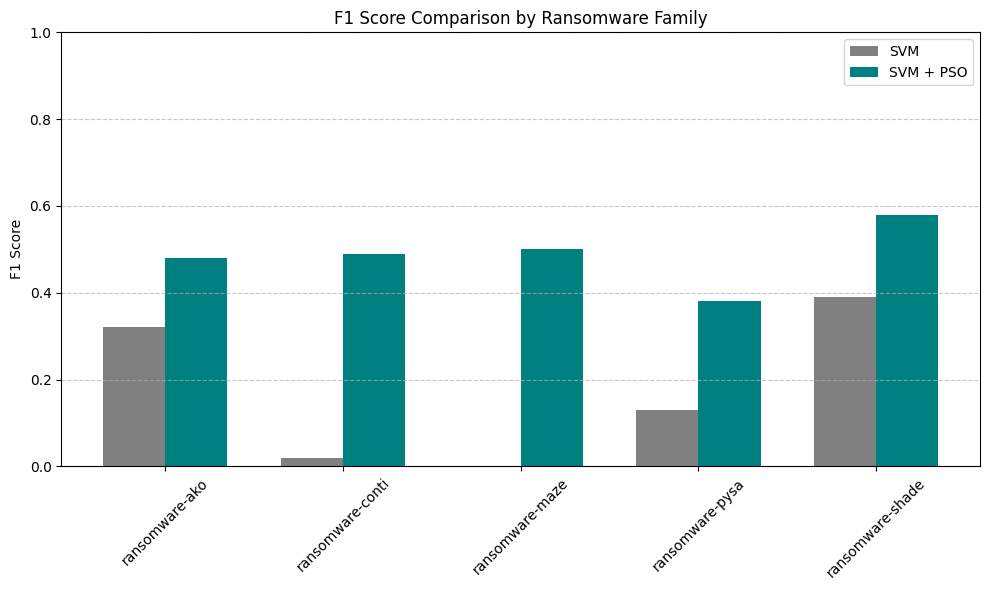

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Labels from your classification report
classes = ['ransomware-ako', 'ransomware-conti', 'ransomware-maze', 'ransomware-pysa', 'ransomware-shade']

# F1-scores from your report (SVM and SVM+PSO)
f1_svm = [0.32, 0.02, 0.00, 0.13, 0.39]
f1_pso = [0.48, 0.49, 0.50, 0.38, 0.58]

x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, f1_svm, width, label='SVM', color='gray')
plt.bar(x + width/2, f1_pso, width, label='SVM + PSO', color='teal')

plt.ylabel('F1 Score')
plt.title('F1 Score Comparison by Ransomware Family')
plt.xticks(x, classes, rotation=45)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [25]:
from pyswarms.single.global_best import GlobalBestPSO
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import numpy as np

# Step 1: Use a smaller dataset for faster tuning
X_small = X_train_scaled[:5000]
y_small = y_train[:5000]

# Step 2: Define the PSO objective function (minimize error)
def svm_pso_objective(params):
    C = params[:, 0]
    gamma = params[:, 1]
    scores = []

    for i in range(len(C)):
        clf = SVC(C=C[i], gamma=gamma[i], kernel='rbf', random_state=42)
        cv_score = cross_val_score(clf, X_small, y_small, cv=3, scoring='accuracy')
        scores.append(1 - cv_score.mean())

    return np.array(scores)

# Step 3: Set the parameter bounds
bounds = ([0.1, 0.0001], [100, 1])  # [C lower, gamma lower], [C upper, gamma upper]

# Step 4: Run PSO (fast settings)
optimizer = GlobalBestPSO(
    n_particles=5,
    dimensions=2,
    options={'c1': 0.5, 'c2': 0.3, 'w': 0.9},
    bounds=bounds
)

# Step 5: Optimize
best_cost, best_pos = optimizer.optimize(svm_pso_objective, iters=10)

# Show results
print("Best cost (1 - accuracy):", best_cost)
print("Best position [C, gamma]:", best_pos)


2025-05-16 00:01:22,819 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=0.0004
2025-05-16 00:02:05,689 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0004000400400112625, best pos: [44.4532454   0.05196937]


Best cost (1 - accuracy): 0.0004000400400112625
Best position [C, gamma]: [44.4532454   0.05196937]
